In [69]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 시드 고정
SEED=42
os.environ["PYTHONHASHSEED"]=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# GPU 설정
gpus=tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Closed 이미지 shape: (124, 124)
Open 이미지 shape: (72, 72)


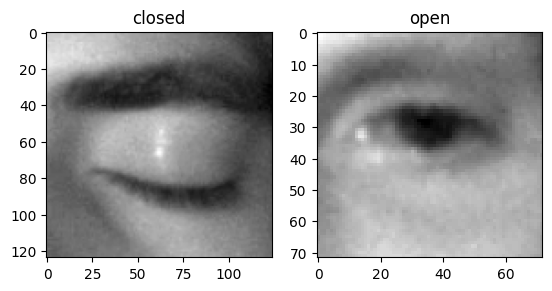

In [70]:
import os
import cv2
import matplotlib.pyplot as plt

closed_dir="../../data/processed/02_kaggle_dataset/train/closed"
open_dir="../../data/processed/02_kaggle_dataset/train/open"

closed_img_path=os.path.join(closed_dir, os.listdir(closed_dir)[0])
open_img_path=os.path.join(open_dir, os.listdir(open_dir)[0])
closed_img=cv2.imread(closed_img_path, cv2.IMREAD_GRAYSCALE)
open_img=cv2.imread(open_img_path, cv2.IMREAD_GRAYSCALE)

print(f"Closed 이미지 shape: {closed_img.shape}")
print(f"Open 이미지 shape: {open_img.shape}")

plt.subplot(1, 2, 1)
plt.title("closed")
plt.imshow(closed_img, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("open")
plt.imshow(open_img, cmap="gray")
plt.show()

In [77]:
IMG_SIZE=64
BATCH_SIZE=32
DATA_PATH="../../data/processed/02_kaggle_dataset/train"

train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

val_datagen=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator=train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator=val_datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False,
    seed=SEED
)

Found 38400 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.


In [78]:
print("클래스 인덱스:", train_generator.class_indices)
print("클래스 분포:", np.unique(train_generator.classes, return_counts=True))

클래스 인덱스: {'closed': 0, 'open': 1}
클래스 분포: (array([0, 1], dtype=int32), array([19200, 19200]))


In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model=Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
#model.summary()

In [ ]:
save_dir="../../src/models/08_newStructure"
os.makedirs(save_dir, exist_ok=True)
checkpoint=ModelCheckpoint(filepath=os.path.join(save_dir, "best_model.keras"),
                           save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)
es=EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)

In [81]:
history = model.fit(train_generator, validation_data=val_generator,
                    epochs=50, callbacks=[checkpoint, es])

Epoch 1/50
1198/1200 [============================>.] - ETA: 0s - loss: 0.4258 - accuracy: 0.7989
Epoch 1: val_accuracy improved from -inf to 0.89052, saving model to ../../src/models/08_newStructure/best_model.keras
1200/1200 [==============================] - 29s 23ms/step - loss: 0.4255 - accuracy: 0.7991 - val_loss: 0.2699 - val_accuracy: 0.8905
Epoch 2/50
1200/1200 [==============================] - ETA: 0s - loss: 0.2068 - accuracy: 0.9211
Epoch 2: val_accuracy improved from 0.89052 to 0.89385, saving model to ../../src/models/08_newStructure/best_model.keras
1200/1200 [==============================] - 28s 23ms/step - loss: 0.2068 - accuracy: 0.9211 - val_loss: 0.2662 - val_accuracy: 0.8939
Epoch 3/50
1198/1200 [============================>.] - ETA: 0s - loss: 0.1295 - accuracy: 0.9506
Epoch 3: val_accuracy did not improve from 0.89385
1200/1200 [==============================] - 28s 23ms/step - loss: 0.1295 - accuracy: 0.9505 - val_loss: 0.3042 - val_accuracy: 0.8752
Epoch 4/5

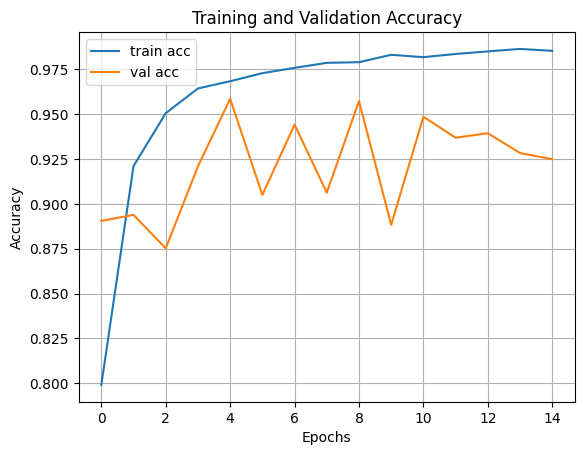

In [82]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()